In [2]:
# 1
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
from ufl import nabla_grad, nabla_div, grad
from scipy.interpolate import interp2d
from abc import abstractmethod

%matplotlib notebook

In [3]:
# 2
nu = 0.1
cDiff = 0.0027
dbar = 1.6925
cS = 0.5
N = 40*3 # Dimension of the grid
M = 100 # Dimension of the matrices
xmax = 1
tol = 1e-10


In [4]:
# 3
def fun(x, y, muX, muY, sigma):
    return gaussian2d(x, y, muX, muY, sigma, sigma)


def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


def gaussian2d(x, y, muX, muY, sigmaX, sigmaY):
    return 1 / (sigmaX * sigmaY * np.sqrt(2 * np.pi)) * np.exp(
        -0.5 * (((x - muX) / sigmaX) ** 2 + ((y - muY) / sigmaY) ** 2))

# N: dimension to, M: dimension from
def interpMat2(N, M, mat):
    xx = np.arange(0, 1.0, 1/(N+1))
    yy = np.arange(0, 1.0, 1/(N+1))
    x = np.arange(0, 1.0, 1/M)
    y = np.arange(0, 1.0, 1/M)
    f = interp2d(x,y,mat)
    mat = f(xx,yy)
    mat = mat.T
    mat = mat.reshape(np.prod(mat.shape))
    return mat

# r = Expression('1 + pow(2, x[0])', degree=2)
# a = Expression('0.5 * (1 - x[0]/xmax)', degree=2, xmax=xmax)
# c_k = Expression('x[0]*x[0]', degree=2)


In [5]:
# 4
x = np.arange(0, 1.0, 1 / M)
y = np.arange(0, 1.0, 1 / M)
X, Y = np.meshgrid(x, y)
zs = np.array(-fun(np.ravel(X), np.ravel(Y), 0.2, 0.5, 0.15)) * 2
zs += np.array(-fun(np.ravel(X), np.ravel(Y), 0.5, 0.3, 0.1)) *0.7
zs += np.array(-fun(np.ravel(X), np.ravel(Y), 0.5, 0.7, 0.1))
zs += np.array(-fun(np.ravel(X), np.ravel(Y), 0.8, 0.3, 0.1)) * 0.8
zs += np.array(-fun(np.ravel(X), np.ravel(Y), 0.8, 0.7, 0.1)) * 1.1


[-0.05636114 -0.06146433 -0.06673266 ... -0.15437131 -0.12958597
 -0.10769815]
[0.99872896 0.99861387 0.99849506 ... 0.99651866 0.99707761 0.99757122]


<IPython.core.display.Javascript object>


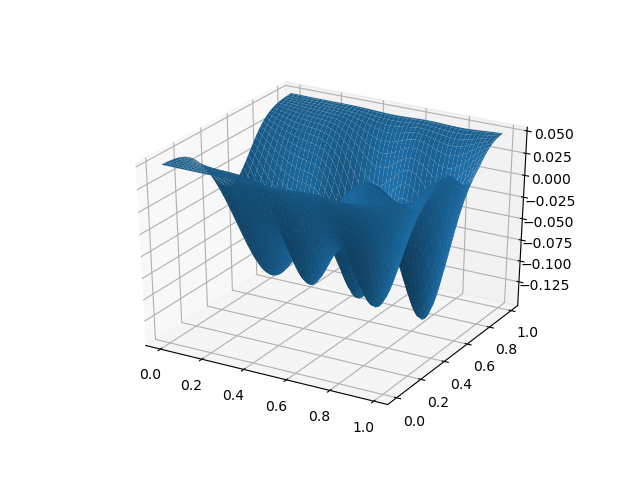

<IPython.core.display.Javascript object>


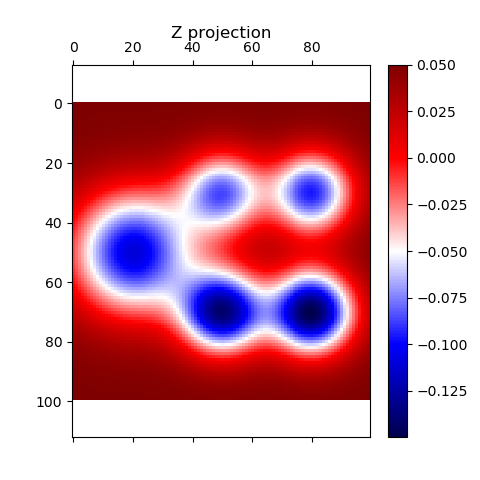

<IPython.core.display.Javascript object>


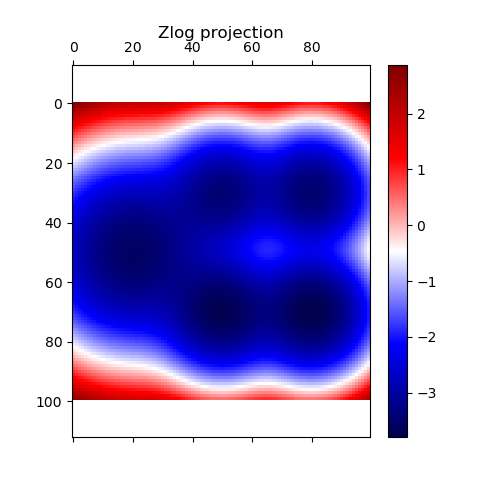

<IPython.core.display.Javascript object>


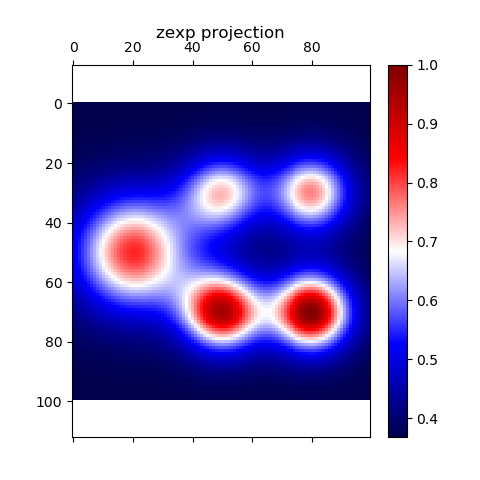

<IPython.core.display.Javascript object>


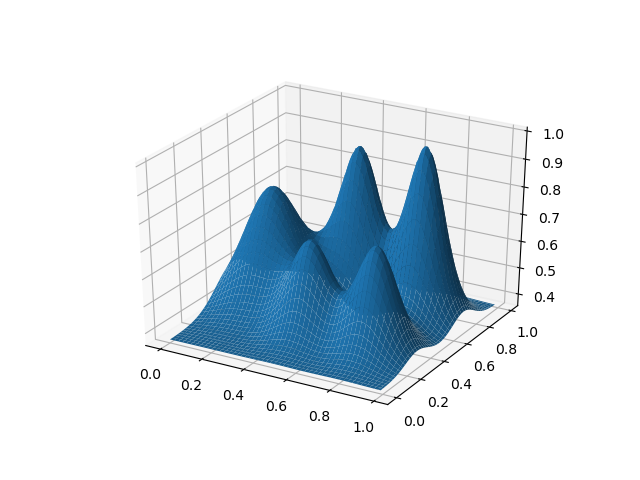

In [6]:
# 4
%matplotlib notebook
print(zs)
print((zs-min(zs))/-min(zs))
Z = (zs-max(zs))/-min(zs)
Z = Z.reshape(X.shape)*0.2
Z +=0.05
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.matshow(Z, aspect=1, cmap=plt.get_cmap('seismic'))
plt.title('Z projection')
plt.colorbar()
plt.axis('equal')
plt.show()

zlog = -np.log(np.abs(zs))
zlog = zlog.reshape(X.shape)
plt.matshow(zlog, aspect=1, cmap=plt.get_cmap('seismic'))
plt.title('Zlog projection')
plt.colorbar()
plt.axis('equal')
plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, zlog)
zexp = np.exp(-((zs-min(zs))/-min(zs)))
zexp = zexp.reshape(X.shape)
plt.matshow(zexp, aspect=1, cmap=plt.get_cmap('seismic'))
plt.title('zexp projection')
plt.colorbar()
plt.axis('equal')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, zexp)


<IPython.core.display.Javascript object>


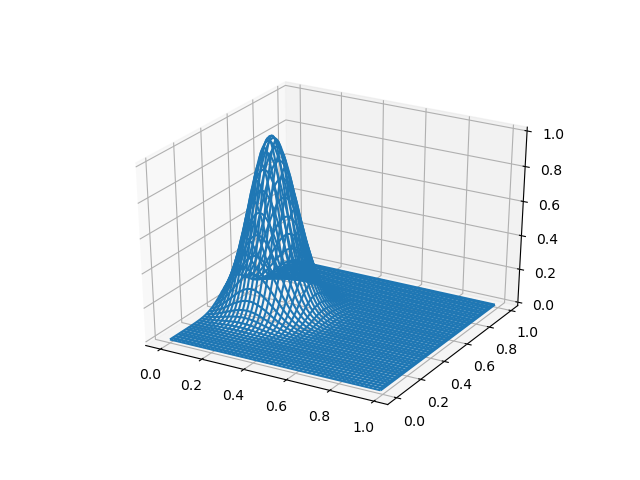

In [7]:
# 4
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(0, 1.0, 1 / M)
y = np.arange(0, 1.0, 1 / M)
X, Y = np.meshgrid(x, y)
ui = np.array(fun(np.ravel(X), np.ravel(Y), 0.2, 0.5, 0.1))
ui = (ui-min(ui))/max(ui)
Ui = ui.reshape(X.shape)
# Z2 = z2.reshape(X.shape)
# ax.plot_surface(X, Y, Ui) 
# ax.plot_surface(X, Y, Z2, linewidth=1) 
ax.plot_wireframe(X, Y, Ui) 


In [8]:
# 5
parameters['reorder_dofs_serial'] = False
mesh = UnitSquareMesh(N, N)  # 8X8 rectangles, each divided in 2 triangle, hence 128 cells, and 81 (9^2) vertices
Vhat = FunctionSpace(mesh, 'P', 1)  # P returns Lagrangian polynomials, 1 is the degree of the FE

## Class makeFunction

In [9]:
class makeFunction():
    def __init__(self, Vhat, N, M, cDth):
        cDthFct = Function(Vhat)
        cDthMat = interpMat2(N, M, cDth)
        cDthFct.vector()[:] = cDthMat

(14641,)


<IPython.core.display.Javascript object>


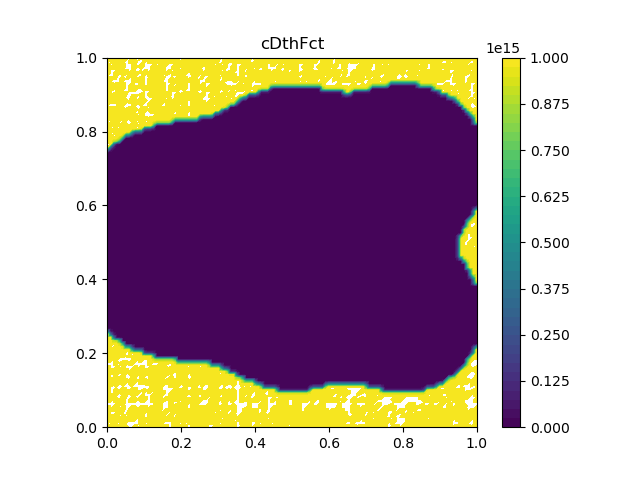

(14641,)


<IPython.core.display.Javascript object>


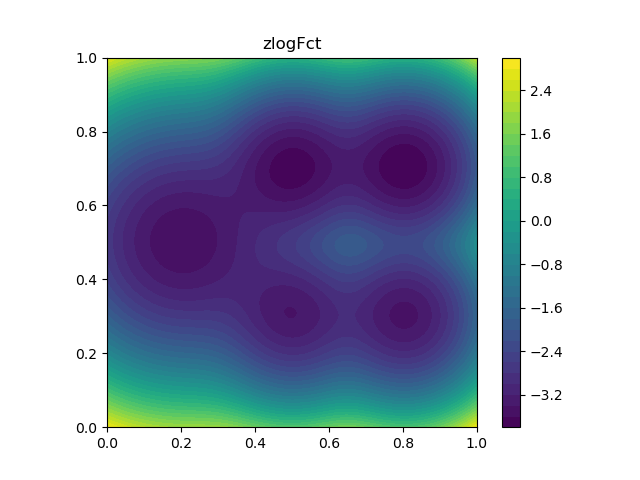

(14641,)


<IPython.core.display.Javascript object>


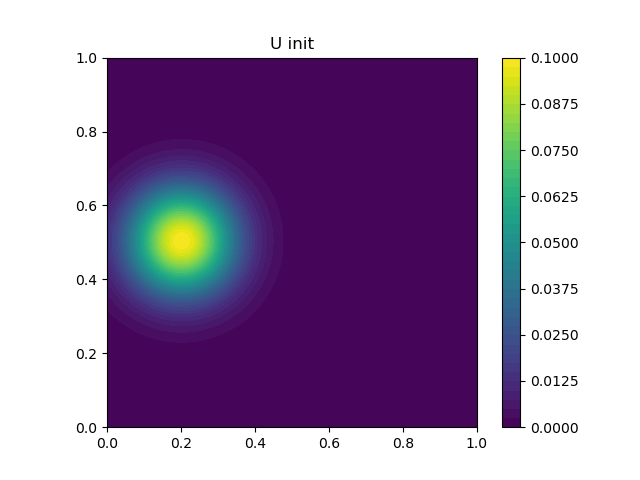

(14641,)


<IPython.core.display.Javascript object>


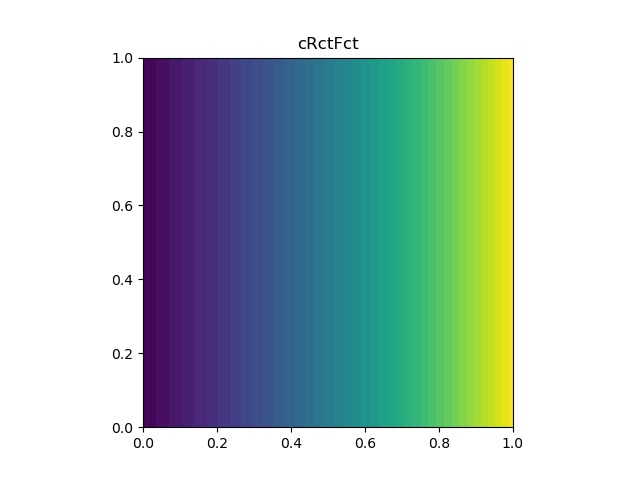

In [10]:
# 6
%matplotlib notebook

uhmst = zexp.reshape(X.shape)
uhmst[uhmst<0.4]=1e-15
cDth = 1. / uhmst.T
cDthFct = Function(Vhat)
cDthMat = interpMat2(N, M, cDth)
cDthFct.vector()[:] = cDthMat
print(cDthMat.shape)
plt.figure()
p=plot(cDthFct)
plt.colorbar(p)
plt.title('cDthFct')
plt.show()

zlog = -np.log(np.abs(zs))
zlogFct = Function(Vhat)
zlogMat = interpMat2(N, M, zlog)
zlogFct.vector()[:] = zlogMat
print(zlogMat.shape)
plt.figure()
p = plot(zlogFct)
plt.colorbar(p)
plt.title('zlogFct')
plt.show()


# Very basic initial conditon
UiFct = Function(Vhat)
UiMat = interpMat2(N, M, 0.1*Ui.T)
UiFct.vector()[:] = UiMat
print(UiMat.shape)
plt.figure()
p = plot(UiFct)
plt.colorbar(p)
plt.title('U init')
plt.show()


def rct(x_, y_):
    return 1 + 2**x_


cRctMat = np.array(rct(np.ravel(X), np.ravel(Y)))
cRctMat = cRctMat.reshape(X.shape)
# plt.figure()
# plt.matshow(cRctMat)
cRctFct = Function(Vhat)
cRctMat = interpMat2(N, M, cRctMat.T)
cRctFct.vector()[:] = cRctMat
print(cRctMat.shape)
plt.figure()
plot(cRctFct)
plt.title('cRctFct')
plt.show()




In [11]:
# 7
def R1(u_):
    uv = u_.vector().get_local()
    cDth = cDthFct.vector().get_local()
    cRct = cRctFct.vector().get_local()
    temp = (cDth * uv)
    temp[temp > dbar] = dbar
    temp = (1 - temp)*cRct
    return temp


def v1():
    return zlogFct


def boundary(x, on_boundary):
    return on_boundary

def v2(u_):
    cAdv = cDthFct.vector().get_local()
    cA = cAFct.vector().get_local()
    cRct = cRctFct.vector().get_local()
    return cA*(1-cAdv)*cRct

def R1(u_):
    uv = u_.vector().get_local()
    cDth = cDthFct.vector().get_local()
    cRct = cRctFct.vector().get_local()
    temp = (cDth * uv)
    temp[temp > dbar] = dbar
    temp = (1 - temp)*cRct
    return temp
# Differtiation rate
# Needs to be 1d --> np-ravel
def a(x_,y_):
    return 0.5*(1 - x_/max(x_))

# PT/ direction of the differentiation
def c_k_x(x_, y_):
    return x_**2

def c_k_y(x_, y_):

    return 0

(14641,)


<IPython.core.display.Javascript object>


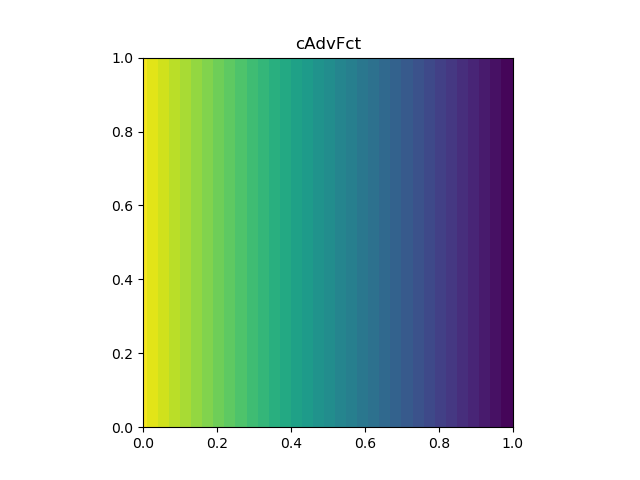

(14641,)


<IPython.core.display.Javascript object>


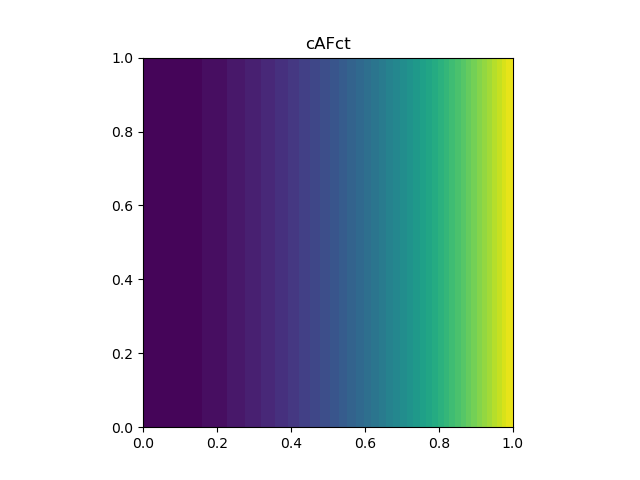

<IPython.core.display.Javascript object>


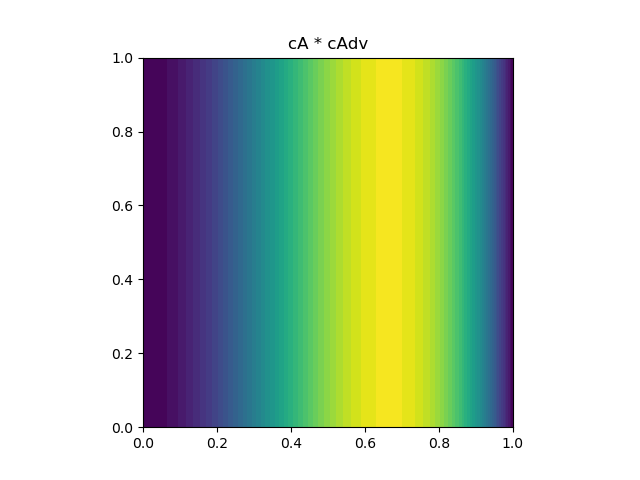

In [12]:
# 6
cAdvMat = np.array(a(np.ravel(X), np.ravel(Y)))
cAdvMat = cAdvMat.reshape(X.shape)
cAdvFct = Function(Vhat)
cAdvMat = interpMat2(N, M, cAdvMat.T)
cAdvFct.vector()[:] = cAdvMat
print(cAdvMat.shape)
plt.figure()
plot(cAdvFct)
plt.title('cAdvFct')
plt.show()


cAMat = np.array(c_k_x(np.ravel(X), np.ravel(Y)))
cAMat = cAMat.reshape(X.shape)
cAFct = Function(Vhat)
cAMat = interpMat2(N, M, cAMat.T)
cAFct.vector()[:] = cAMat
print(cAMat.shape)
plt.figure()
plot(cAFct)
plt.title('cAFct')
plt.show()

plt.figure()
plot(cAFct*cAdvFct)
plt.title('cA * cAdv')
plt.show()

# Vhat2d = VectorFunctionSpace(mesh, 'P', 1)
# V2Fct = Function(Vhat) 
# V2Fct.vector()[:] = v2(u)
# plot(V2Fct)


<IPython.core.display.Javascript object>


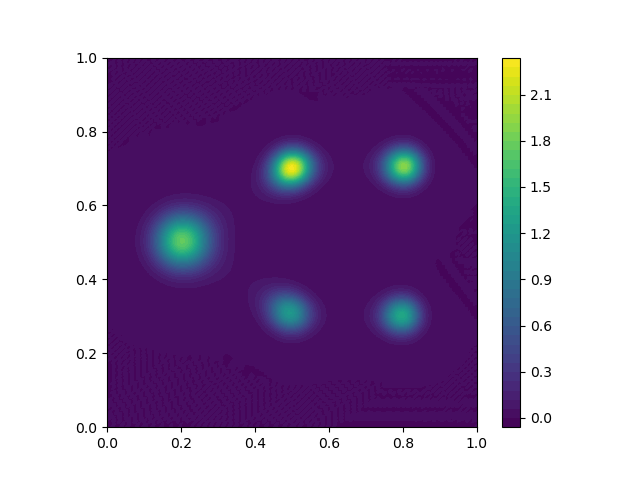

In [13]:
# 8
# %matplotlib notebook

zero = Constant(0)
bc = DirichletBC(Vhat, zero, boundary)

u = TrialFunction(Vhat)  # here it is just defined as an unknown to define a.
v = TestFunction(Vhat)
u_n = Function(Vhat)
R = Function(Vhat)
V2Fct = Function(Vhat) 

u_n = interpolate(UiFct, Vhat) # initial value

# plt.figure()
# p = plot(u_n)
# plt.colorbar(p)
# plt.show()

T = 4.0  # final time
num_step = 10
dt = T / num_step
k = 1./dt
tol = 1e-10

R.vector()[:] = R1(u_n)
V2Fct.vector()[:] = v2(u_n)

F = dot((u-u_n)*k,v)*dx + nu * dot(grad(u), grad(v)) * dx + dot(nabla_grad(v1())*u, nabla_grad(v)) * dx - \
    dot( R*u, v) * dx - dot(V2Fct*u, v.dx(0))* dx - dot(Constant(0), v.dx(1))* dx
#F = dot((u-u_n)*k,v)*dx + nu * dot(grad(u), grad(v)) * dx + dot(nabla_grad(v1())*u, nabla_grad(v)) * dx - \
#    dot( R*u, v) * dx - dot(V2Fct*u, nabla_grad(v)) * dx
# - dot( v2(u), grad(v)) * dx
# - dot( R(u), v) * dx
# - dot( v2(u), grad(v)) * dx
# - dot( Adv(u), grad(v)) * dx
# dot(nabla_grad(zlogFct)*u, nabla_grad(v)) * dx

u = Function(Vhat)
a = lhs(F)
L = rhs(F)
t = 0

## uncomment to save the solution onto pvd files. Can be used to plot dynamically in paraview
# vtkfile = File('framework/solution.pvd')
# vtkfile << (u_n, t)

for n in range(num_step):
    R.vector()[:] = R1(u_n)
    V2Fct.vector()[:] = v2(u_n)
    t+=dt
    solve(a == L, u, bc)
    u_e = interpolate(u_n, Vhat)
    error = np.abs(u_e.vector().get_local() - u.vector().get_local()).max()
#     print('t = %.2f: difference = %.3g' % (t, error))
    if (error < tol):
        break
#     print(max(u.vector()))
#     print(min(u.vector()))
#     vtkfile << (u, t)
#     plt.figure()
#     p = plot(u)
#     plt.colorbar(p)
#     plt.show()
    u_n.assign(u)
    
# print(u.vector().get_local().shape)
# print(max(u.vector()))
# print(min(u.vector()))

plt.figure()
p = plot(u)
plt.colorbar(p)
plt.show()


<IPython.core.display.Javascript object>


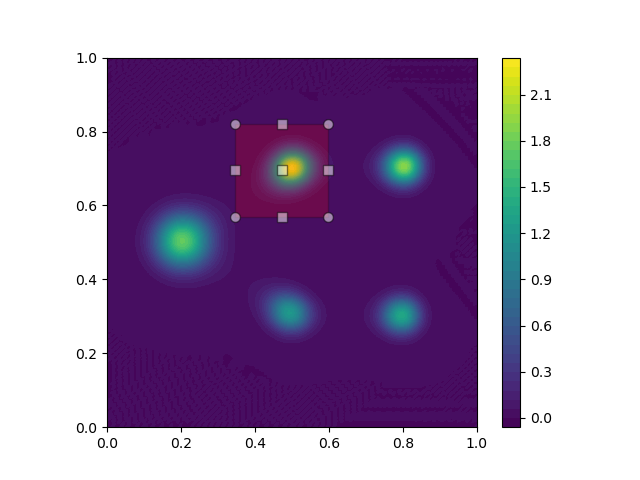


      click  -->  release


In [14]:
# 9
from matplotlib.widgets import RectangleSelector
def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    print("(%3.2f, %3.2f) --> (%3.2f, %3.2f)" % (x1, y1, x2, y2))
    print(" The button you used were: %s %s" % (eclick.button, erelease.button))



fig, current_ax = plt.subplots()                 # make a new plotting range
# p = plot(UiFct)
p = plot(u)
plt.colorbar(p)
def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        print(' RectangleSelector activated.')
        toggle_selector.RS.set_active(True)

print("\n      click  -->  release")

# drawtype is 'box' or 'line' or 'none'
toggle_selector.RS = RectangleSelector(current_ax, line_select_callback,
                                       drawtype='box', useblit=True,
                                       button=[1, 3],  # don't use middle button
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
plt.connect('key_press_event', toggle_selector)
plt.show()



In [16]:
# 9
# print(toggle_selector.RS.geometry)
x1, x2, y1 ,y2, z = toggle_selector.RS.geometry.T
# print(x1)
# print(x2)
# print(y1)
# print(y2)
p1 = Point(x1[0], x1[1])
p2 = Point(y1[0], y1[1])

NewMesh = RectangleMesh(p1,p2,N,N)

VInt = FunctionSpace(NewMesh, "Lagrange", 2)
uInt = project(u, VInt)
print(assemble(uInt*dx))
print(assemble(u*dx))
# print(assemble(uInt*ds))
# print(assemble(uInt*dx))

0.0007339968475142204
0.08076122032604827


## BIN CLASS (x,y,r,n,state)
This class builds an object that represents a square mesh around the coordinate (x,y) and of side length 2*r and 2*n triangles. This helps to calculate the needed parameters for the next steps. 
The function "integrate(u)" integrates the function u over the selected mesh.

The state of the object Bin.shape can be set to 'c' and the integration will be performed on a circle mesh based on the coordinate (x,y) and of radius r and consisting of 2*n triangles.

Remark: the circle shape is less precise, but with a higher number of degree of freedom, the correctness stands  

In [38]:
from Bin import *

In [26]:
bin1.setState('c')
lower= bin1.lowerHalfOutflow(u)
upper= bin1.upperHalfOutflow(u)
print(lower+upper)
print(bin1.outflow(u))
print(lower+upper-bin1.outflow(u))


6.013972739882964
6.029964470526899
-0.01599173064393522


<IPython.core.display.Javascript object>


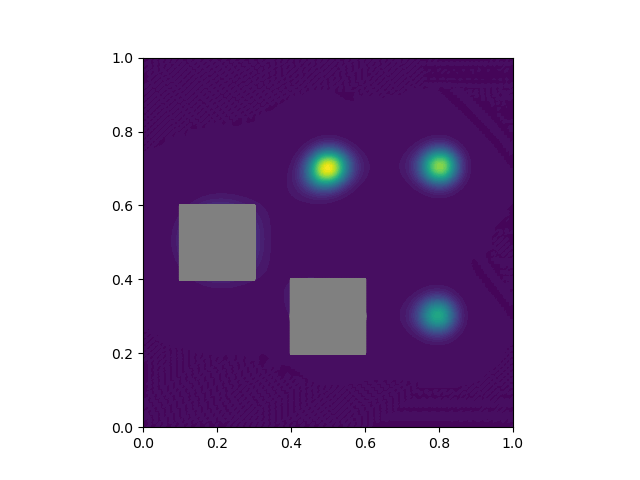

0.024986744049978072
0.00987898376566067


In [39]:
# 9
# Example of the definitions of several bins, and plotting of their respective mesh on the last generated figure
plt.figure()
plot(u)
bin1 = Bin(0.2, 0.5, 0.1, N, '')
print(bin1.integrate(u))
plot(bin1.mesh)
bin2 = Bin(0.5, 0.3, 0.1, N, 'c')
print(bin2.integrate(u))
plot(bin2.mesh)
# plt.show()
bin2.setState('s')
bin2.getMesh()
bin2.setState('c')
plot(bin2.mesh)
plt.show()


In [19]:
print(bin1.maxValue(u))
print(bin1.minValue(u))
print(bin2.maxValue(u))
print(bin2.minValue(u))

1.751983658624889
0.16563047175698156
2.3228708446732833
0.02239158985467741


In [20]:
print(bin1.outflow(u))
print(bin2.outflow(u))
print(bin1.inflow(u))
# binTest = BinState(0.5, 0.7, 0.15, N)
# bin1.setState('c')
print(bin1.outflow(u))

6.029964470526899
2.408495992153765
-6.029964470526899
6.029964470526899


In [21]:
# test for bin1
p1_ = Point(0.1, 0.6)
p2_ = Point(0.3, 0.4)
# NewMesh = RectangleMesh(p1_,p2_,N,N)        
domain = Circle(Point(0.2,0.5),0.1)
NewMesh = generate_mesh(domain, N)
VInt = FunctionSpace(NewMesh, "Lagrange", 2)
n = FacetNormal(NewMesh)
uOut = project(u, VInt)
flux = -dot(grad(uOut),n)*ds
print(assemble(flux))


6.029964470526899


In [22]:
def boundary_down(x, on_boundary):
    return on_boundary and x[1] <= 0.5

def boundary_up(x, on_boundary):
    return on_boundary and x[1] >= 0.5


VInt = FunctionSpace(NewMesh, "Lagrange", 2)
nUD = FacetNormal(NewMesh)
uUD = project(u, VInt)

bcUp = AutoSubDomain(boundary_up)
bcDown = AutoSubDomain(boundary_down)

boundaries =  MeshFunction('size_t', NewMesh, NewMesh.topology().dim()-1)
dsUD = Measure('ds', domain = NewMesh, subdomain_data=boundaries)
bcUp.mark(boundaries, 1)
bcDown.mark(boundaries, 2)

fluxU = -dot(grad(uUD), nUD) * dsUD(1)
fluxL = -dot(grad(uUD), nUD) * dsUD(2)
upper = assemble(fluxU)
lower = assemble(fluxL)

print(upper)
print(lower)
print(upper + lower)
print(bin1.outflow(u))

3.2517957673737072
2.7621769725092564
6.013972739882964
6.029964470526899


In [25]:
print(bin2.integrate(UiFct))
print(bin2.integrate(cDthFct))
print(bin2.integrate(cRctFct))
print(bin2.integrate(cAFct))
print(bin1.integrate(v1()))
print(bin1.integrate(V2Fct))

1.585580854317027e-05
0.03904594618808301
0.07574064925888226
0.007802469631502566
-0.10888214192671924
-0.000901524480686583


In [24]:
print(bin1.outflow(u))
print(bin2.outflow(u))


6.029964470526899
2.408495992153765
